<a href="https://colab.research.google.com/github/benbaz-2/comp551/blob/Aziz/a2_aziz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Text(0, 0.5, 'y')

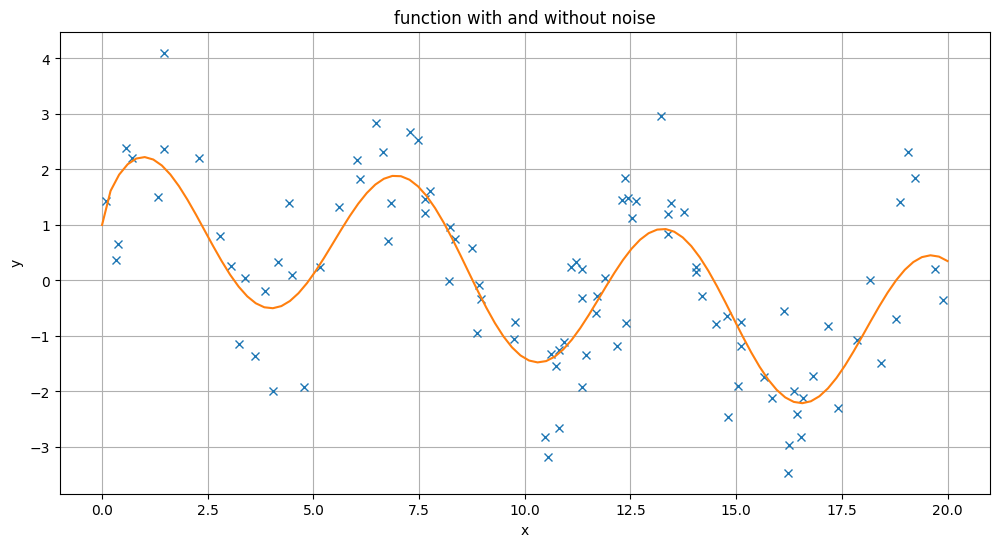

In [2]:
# Generate the data
x = np.random.uniform(0, 20, 100)
x = np.sort(x)

f = lambda x: np.sin(np.sqrt(x)) + np.cos(x) + np.sin(x)
e = np.random.normal(0, 1, 100)
y = f(x) + e

# Define the range for plotting
range_x = np.linspace(0, 20, 100)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, y, 'x')
plt.plot(range_x, f(range_x))
plt.grid()

plt.title('function with and without noise')
plt.xlabel('x')
plt.ylabel('y')

Text(0.5, 0.98, 'gaussian functions')

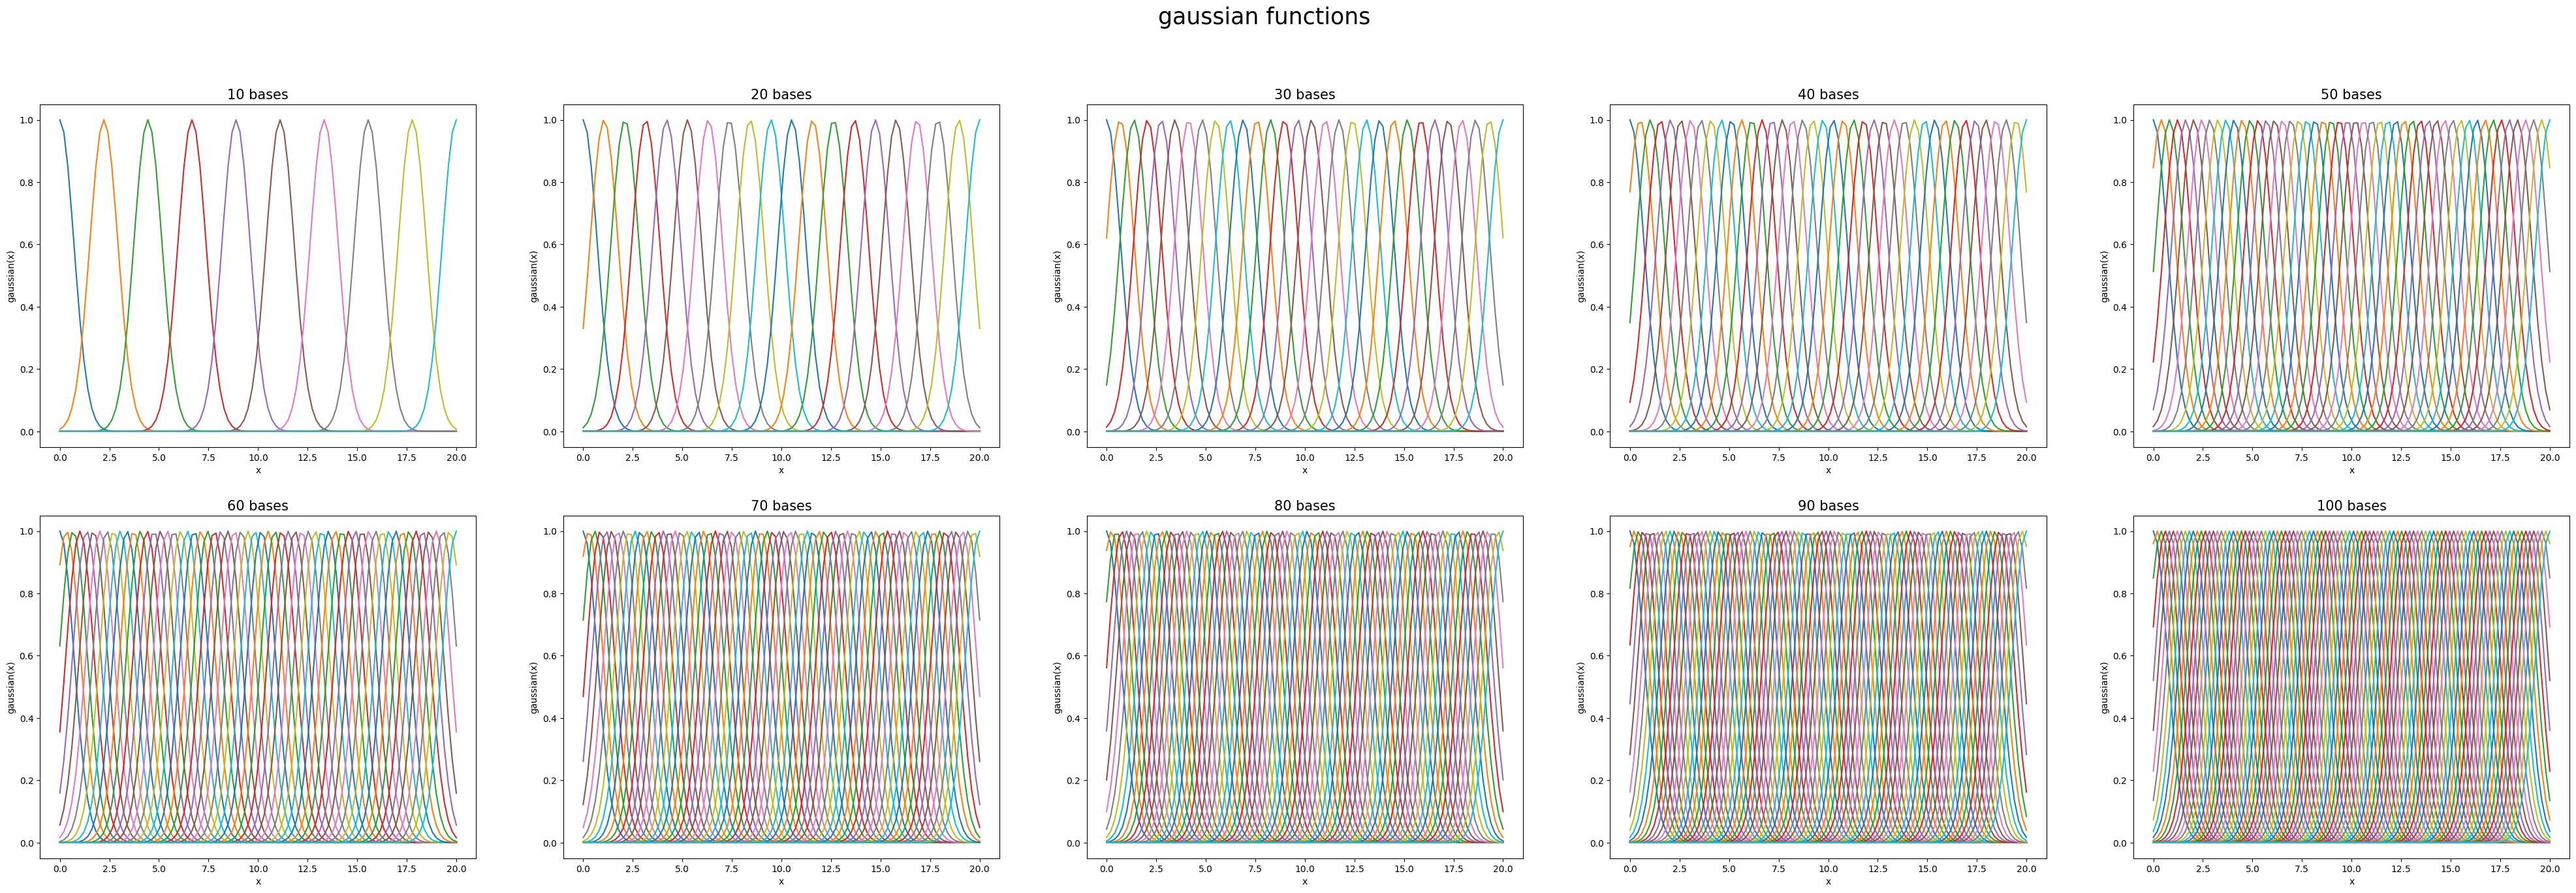

In [3]:
# Define the gaussian function
gaussian = lambda x, mu: np.exp(-(x-mu)**2)

# Plot the gaussian functions with different number of bases
num_gaussian_bases = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]        # initialize an array with the number of bases used n

fig, ax = plt.subplots(2, 5, figsize=(50, 15))
fig.suptitle('Gaussian functions with different means', fontsize=20)
ax = ax.flatten()                                                     # This makes it easier to iterate over the ax array

for i, n in  enumerate(num_gaussian_bases):
  mus = np.linspace(0, 20, n)                                         # generate the means mus of the gaussian basis functions

  for mu in mus:                                                      # plot the gaussian functions for each number of basis functions
      ax[i].plot(range_x, gaussian(range_x, mu))

  ax[i].set_title(f'{n} bases', fontsize=15)
  ax[i].set_xlabel('x')
  ax[i].set_ylabel('gaussian(x)')

fig.suptitle('gaussian functions', fontsize=25)

In [4]:
# Implementation of the gaussian regression model
class GaussianRegression:
  def __init__(self, n, add_bias=True):
    self.add_bias = add_bias
    self.n = n                                        # n is the number of gaussian bases used
    self.w = None

  # This method creates the design matrix X
  def gaussian_bases(self, x):
    X = np.zeros((len(x), self.n))
    mus = np.linspace(0, 20, self.n)
    for i, mu in enumerate(mus):
      X[:, i] = gaussian(x, mu)
    return X

  def fit(self, x, y):
    X = self.gaussian_bases(x)                      # Generate the design matrix
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
    return self

  def predict(self, x):
    X = self.gaussian_bases(x)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ self.w

  def loss(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.sum((y - self.predict(x))**2)                       # Return the sum of squared error


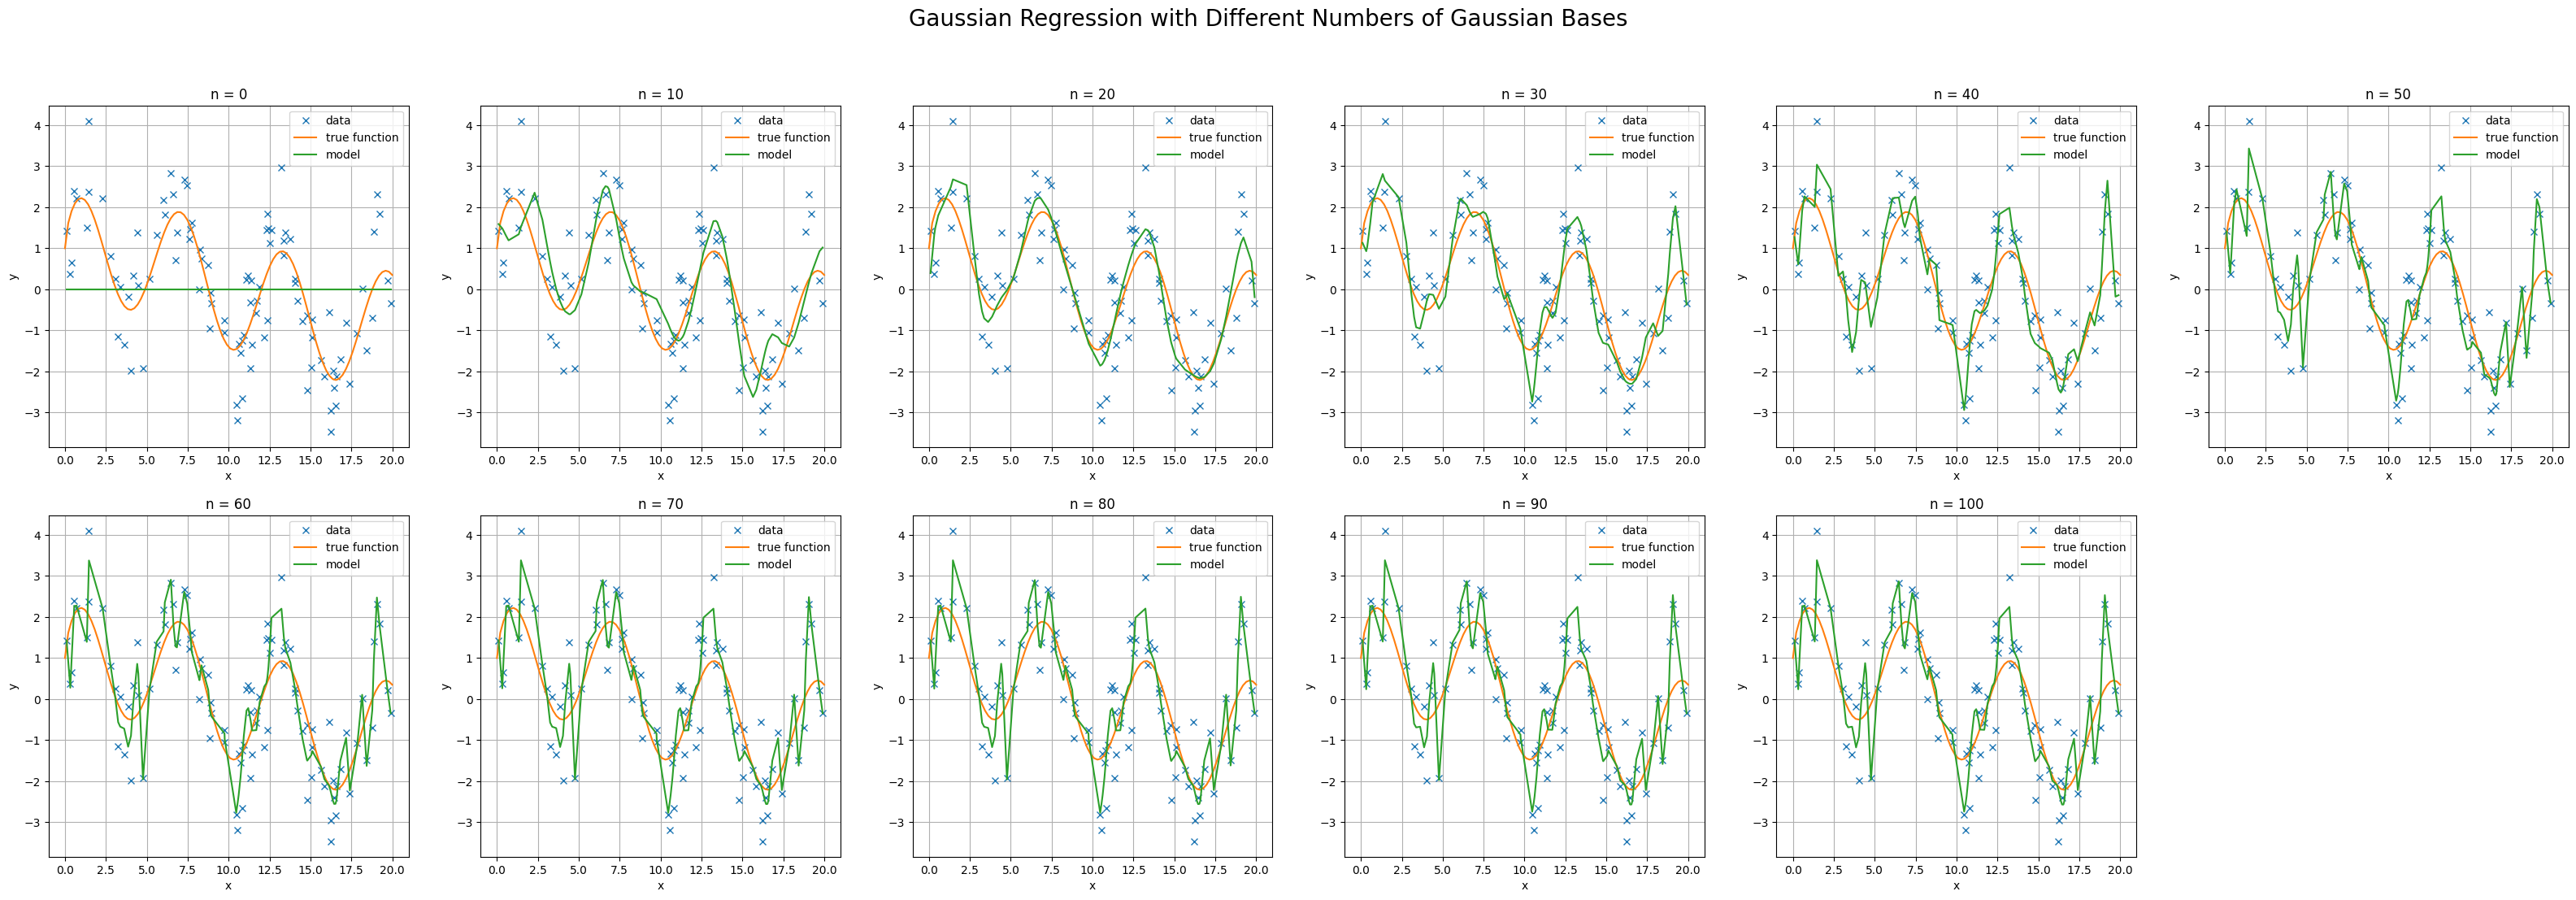

In [6]:
# generate predictions using different numbers of gaussian bases
predictions = []

num_gaussian_bases = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for n in num_gaussian_bases:
  model = GaussianRegression(n)
  model.fit(x, y)
  predictions.append(model.predict(x))

# plot the predictions alongside the original function and data
fig, ax = plt.subplots(2, 6, figsize=(40, 12))
fig.suptitle('Gaussian Regression with Different Numbers of Gaussian Bases', fontsize=20)
ax = ax.flatten()

for i, p in enumerate(predictions):
  ax[i].set_title(f'n = {num_gaussian_bases[i]}')
  ax[i].set_xlabel('x')
  ax[i].set_ylabel('y')
  ax[i].plot(x, y, 'x', label='data')
  ax[i].plot(range_x, f(range_x), label='true function')
  ax[i].plot(x, p, label='model')
  ax[i].legend()
  ax[i].grid()

ax[-1].set_visible(False)

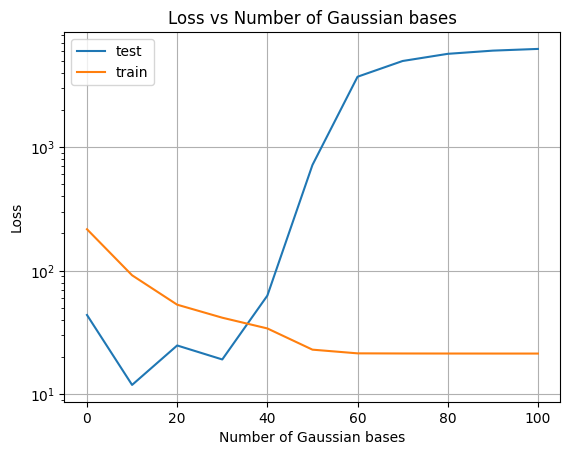

In [7]:
# This part is used for model evaluation. We want to find the optimum number of bases
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

test = []
train = []

for n in num_gaussian_bases:
  model = GaussianRegression(n)
  model.fit(x_train, y_train)
  test.append(model.loss(x_test, y_test))
  train.append(model.loss(x_train, y_train))

plt.plot(num_gaussian_bases, test, label='test')
plt.plot(num_gaussian_bases, train, label='train')
plt.legend()
plt.xlabel('Number of Gaussian bases')
plt.ylabel('Loss')
plt.title('Loss vs Number of Gaussian bases')
plt.yscale('log')                                   # Note the performance gets worse very quickly at some point due to overfitting. This is a log scale.
plt.grid()

In [15]:
# Implementation of the gaussian regression model with lasso and ridge
class GaussianRegression:
  def __init__(self, n, add_bias=True, epsilon=0.1, alpha=0.1, lambdaa=0.3, max_iter=100, lasso=False, ridge=False):
    self.add_bias = add_bias
    self.n = n                                        # n is the number of gaussian bases used
    self.epsilon = epsilon
    self.alpha = alpha
    self.lambdaa = lambdaa
    self.max_iter = max_iter
    self.w = None
    self.lasso = lasso
    self.ridge = ridge

  # This method creates the design matrix X
  def gaussian_bases(self, x):
    X = np.zeros((len(x), self.n))
    mus = np.linspace(0, 20, self.n)
    for i, mu in enumerate(mus):
      X[:, i] = gaussian(x, mu)
    return X

  def fit(self, x, y):
    X = self.gaussian_bases(x)                      # Generate the design matrix

    if y.ndim == 1:
      y = y.reshape(-1, 1)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))

    if self.lasso:
      self.w = self.lasso_fit(X, y)
      return self

    elif self.ridge:
      I = np.eye(X.shape[1])
      self.w = np.linalg.pinv(X.T @ X + self.lambdaa * I) @ X.T @ y
      return self

    else:
      self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
      return self

  def lasso_fit(self, X, y):
    w = np.zeros((X.shape[1], 1))
    e = np.inf
    i = 0
    while e > self.epsilon and i < self.max_iter:
      N, D = X.shape
      gradient = 1/N * X.T @ (X @ w - y) + self.lambdaa * np.sign(w +1e-6)
      w = w - self.alpha * gradient
      e = np.linalg.norm(gradient)
      gs.append(e)
      i += 1
    return w

  def predict(self, x):
    X = self.gaussian_bases(x)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ self.w

  def loss(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.sum((y - self.predict(x))**2)                       # Return the sum of squared error


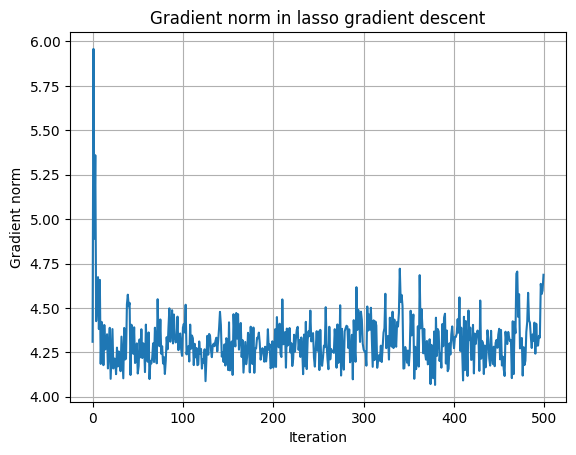

In [62]:
n = 70
gs = []
lasso = GaussianRegression(n, lasso=True, alpha=5e-1, lambdaa=0.5, epsilon=0.1, max_iter=1000)
lasso.fit(x, y)

plt.plot(gs[:500])
plt.title('Gradient norm in lasso gradient descent')
plt.xlabel('Iteration')
plt.ylabel('Gradient norm')
plt.grid()

Text(0.5, 1.0, 'Lasso and Ridge regression')

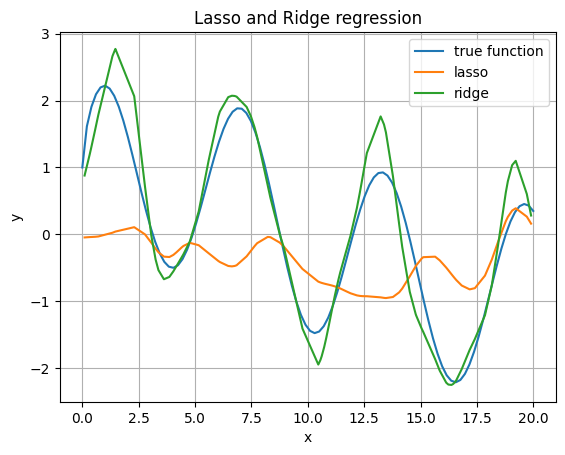

In [61]:
n = 70
lasso = GaussianRegression(n, lasso=True, alpha=5e-1, lambdaa=0.5, epsilon=0.1, max_iter=1000)
lasso.fit(x, y)
ridge = GaussianRegression(n, ridge=True)
ridge.fit(x, y)

plt.plot(range_x, f(range_x), label='true function')
plt.plot(x, lasso.predict(x), label='lasso')
plt.plot(x, ridge.predict(x), label='ridge')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lasso and Ridge regression')